# Set up your environment

Use the mlgeo enviroment from class

update with ClusTremor-main/requirements.txt

# Load data and split train-test

1. **Load Data**  
   Loads seismic data from `"Input.npy"` using `np.load()` with memory mapping, which allows accessing data directly from the disk without loading it all into memory.

2. **Split Data**  
   Splits the data into 80% training and 20% testing using `train_test_split`, ensuring randomness for a balanced dataset.

3. **Convert to PyTorch Tensors**  
   Converts the training and test sets to PyTorch tensors (`float32` type), necessary for compatibility with PyTorch models.

4. **Prepare DataLoader**  
   Sets up data loaders for batching with `DataLoader`, assigning a batch size of 32. Training data is shuffled for better model training, while test data is not shuffled.

### Summary
This script loads, splits, converts, and batches seismic data, preparing it for model training.

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load data
print("Beginning to load file...")

# Load the seismic data (adjust file path as needed)
data_file = np.load("Input.npy", mmap_mode='r', allow_pickle=True)

print("File loaded")

# Step 2: Split data into train and test sets
print("Split data into training and testing sets")
train_data, test_data = train_test_split(data_file, test_size=0.2, random_state=46, shuffle=True)

print('Size of data_file:', data_file.shape)
print('Size of train set:', train_data.shape)
print('Size of test set:', test_data.shape)

# Step 3: Convert the data into PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)

# Step 4: Prepare DataLoader for batching
batch_size = 32

# Create TensorDataset and DataLoader for training and testing sets
train_dataset = TensorDataset(train_data_tensor, train_data_tensor)  # (input, target) both are the same for autoencoder
test_dataset = TensorDataset(test_data_tensor, test_data_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Data is now ready for training

Beginning to load file...
File loaded
Split data into training and testing sets
Size of data_file: (2390, 96, 128)
Size of train set: (1912, 96, 128)
Size of test set: (478, 96, 128)


# Autoencoder architecture construction

Import the dependencies first!
```python
pip install torch
pip install torchinfo
```

1. **Set Seed for Reproducibility**  
   Sets a seed (`sd = 46`) to ensure consistent model results across runs.

2. **Padding Calculation Function**  
   Defines `calculate_same_padding`, which calculates the padding needed for "same" padding in convolutional layers to maintain consistent output sizes.

3. **Autoencoder Class Definition**  
   Defines an `Autoencoder` class that builds an encoder-decoder structure:
   - **Encoder**: Uses several 2D convolutional layers with ELU activation, reducing data dimensions.
   - **Fully Connected Layers**: Encodes the compressed representation to a small latent space and reconstructs it with fully connected layers.
   - **Decoder**: Expands the encoded data using transposed convolutions, reversing the encoding to approximate the original input dimensions.

4. **Model Setup**  
   - Creates an instance of `Autoencoder`.
   - Moves the model to a GPU if available (`device` check) to speed up computation.
   - Defines a dummy input tensor (size 1, 1, 96, 128) for model testing.

5. **Model Summary**  
   Uses `torchinfo.summary` to display the model structure and layer details, helping verify the architecture and dimensions.

### Summary
This code builds an autoencoder for seismic data, compressing it into a lower-dimensional representation and reconstructing it. The model is then moved to a GPU (if available) and tested with dummy input to check layer connections and output dimensions.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

# Set the seed for reproducibility
sd = 46
torch.manual_seed(sd)

# Function to calculate "same" padding for strided convolutions
def calculate_same_padding(kernel_size, stride):
    return ((stride - 1) + (kernel_size - 1)) // 2

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers with manually calculated "same" padding
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(7, 5), stride=2, padding=(calculate_same_padding(7, 2), calculate_same_padding(5, 2)))
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(5, 3), stride=2, padding=(calculate_same_padding(5, 2), calculate_same_padding(3, 2)))
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(5, 3), stride=2, padding=(calculate_same_padding(5, 2), calculate_same_padding(3, 2)))
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(5, 3), stride=2, padding=(calculate_same_padding(5, 2), calculate_same_padding(3, 2)))

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 6 * 8, 24)  # Adjusted based on conv output
        self.fc2 = nn.Linear(24, 3072)

        # Decoder layers
        self.fc3 = nn.Linear(3072, 64 * 6 * 8)  # Adjust based on the shape before flattening
        self.conv_transpose1 = nn.ConvTranspose2d(64, 32, kernel_size=(5, 3), stride=2, padding=(2, 1), output_padding=(1, 1))  # Adjust output_padding
        self.conv_transpose2 = nn.ConvTranspose2d(32, 16, kernel_size=(5, 3), stride=2, padding=(2, 1), output_padding=(1, 1))
        self.conv_transpose3 = nn.ConvTranspose2d(16, 8, kernel_size=(5, 3), stride=2, padding=(2, 1), output_padding=(1, 1))
        self.conv_transpose4 = nn.ConvTranspose2d(8, 1, kernel_size=(7, 5), stride=2, padding=(3, 2), output_padding=(1, 1))  # Adjust padding/output_padding

    def forward(self, x):
        # Encoder
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))

        # Save shape for later use in decoder
        shape_before_flattening = x.shape

        # Fully connected layers
        x = self.flatten(x)
        encoded = F.elu(self.fc1(x))
        x = F.elu(self.fc2(encoded))

        # Decoder
        x = F.elu(self.fc3(x))
        x = x.view(-1, 64, 6, 8)  # Reshape to the shape before flattening
        x = F.elu(self.conv_transpose1(x))
        x = F.elu(self.conv_transpose2(x))
        x = F.elu(self.conv_transpose3(x))
        decoded = self.conv_transpose4(x)  # No activation for output layer

        return decoded, encoded


# Create model instance
autoencoder = Autoencoder()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
autoencoder.to(device)

# Ensure that the input data is on the same device (for example, random input)
dummy_input = torch.randn(1, 1, 96, 128).to(device)  # Simulate a batch of size 1

# Now use torchinfo for the summary
summary(autoencoder, input_size=(1, 1, 96, 128))


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 1, 96, 128]           --
├─Conv2d: 1-1                            [1, 8, 48, 64]            288
├─Conv2d: 1-2                            [1, 16, 24, 32]           1,936
├─Conv2d: 1-3                            [1, 32, 12, 16]           7,712
├─Conv2d: 1-4                            [1, 64, 6, 8]             30,784
├─Flatten: 1-5                           [1, 3072]                 --
├─Linear: 1-6                            [1, 24]                   73,752
├─Linear: 1-7                            [1, 3072]                 76,800
├─Linear: 1-8                            [1, 3072]                 9,440,256
├─ConvTranspose2d: 1-9                   [1, 32, 12, 16]           30,752
├─ConvTranspose2d: 1-10                  [1, 16, 24, 32]           7,696
├─ConvTranspose2d: 1-11                  [1, 8, 48, 64]            1,928
├─ConvTranspose2d: 1-12                  [1, 1, 9

# Initial training phase: Pretraining the autoencoder

1. **Define Constants**  
   Sets hyperparameters for training:
   - `NUM_OF_EPOCHS`: Total number of training epochs.
   - `initial_lr`: Initial learning rate for the optimizer.
   - `decay_steps` and `decay_rate`: Control learning rate decay with the scheduler.
   - `patience`: Number of epochs without improvement to trigger early stopping.

2. **Model, Loss, Optimizer, and Scheduler Setup**  
   - Initializes the autoencoder model, MSE loss function, Adam optimizer, and exponential learning rate scheduler for gradual learning rate reduction.

3. **Setup CSV Logger and Early Stopping**  
   Creates a dictionary to log epoch metrics (`csv_log`) and initializes variables for tracking best validation loss and patience counter for early stopping.

4. **Training Loop**  
   For each epoch:
   - **Training Phase**: 
     - The model is set to training mode.
     - Loops over training batches, calculates the MSE loss between outputs and inputs, backpropagates, and updates weights.
   - **Validation Phase**:
     - Sets the model to evaluation mode, calculates the validation loss without gradient updates.

5. **Logging and Early Stopping**  
   - Averages and logs training and validation losses and the current learning rate.
   - Checks if validation loss improves; if not, increments the early stopping counter and stops if patience is exceeded.

6. **Learning Rate Scheduler**  
   Updates the learning rate after each epoch with `scheduler.step()` to gradually reduce the learning rate.

7. **Save Training Log**  
   Exports the training log to a CSV file named `pretrain_log.csv` for analysis.

### Summary
This code defines and executes the initial training phase of the autoencoder, including loss computation, logging, learning rate decay, and early stopping to prevent overfitting.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import pandas as pd

# Define constants
NUM_OF_EPOCHS = 500
initial_lr = 0.001
decay_steps = 1000
decay_rate = 0.5
patience = 30

# Initialize model, optimizer, and scheduler
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = ExponentialLR(optimizer, gamma=decay_rate**(1 / decay_steps))

# Setup CSV logger
csv_log = {'epoch': [], 'train_loss': [], 'val_loss': [], 'learning_rate': []}

# Early stopping parameters
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop with early stopping and logging
for epoch in range(NUM_OF_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        
        data = data.unsqueeze(1)
        inputs = data.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            
            data = data.unsqueeze(1)
            inputs = data.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()

    # Average losses
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)

    # Log values
    current_lr = scheduler.get_last_lr()[0]
    csv_log['epoch'].append(epoch + 1)
    csv_log['train_loss'].append(train_loss)
    csv_log['val_loss'].append(val_loss)
    csv_log['learning_rate'].append(current_lr)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print progress
    print(f"Epoch {epoch+1}/{NUM_OF_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

    # Step the learning rate scheduler
    scheduler.step()

# Save the CSV log
pd.DataFrame(csv_log).to_csv('pretrain_log.csv', index=False)


# Visually evaluate autoencoder reconstruction

1. **Load Training Log Data**  
   Reads the CSV file `'pretrain_log.csv'`, which contains the logged training and validation loss values across epochs.

2. **Plot Reconstruction Loss**  
   - Creates a plot with the training and validation losses over epochs.
   - Uses blue and dark orange lines to differentiate training and validation loss curves.

3. **Plot Formatting**  
   - Sets labels for the x-axis (`Epoch`) and y-axis (`Loss`) and a title describing the plot: `'Reconstruction loss of the autoencoder'`.
   - Increases font size for readability on labels, ticks, and the legend.
   - `tight_layout()` adjusts the figure to fit elements well.

4. **Display and Save Plot**  
   - `plt.show()` displays the plot.
   - `fig.savefig()` saves the plot as `'ReconstructionLoss.png'` at 100 DPI for analysis or reporting.

This code visualizes the reconstruction loss of the autoencoder over epochs, helping assess model training progress and convergence. The plot shows trends in training and validation loss, indicating how well the model generalizes.

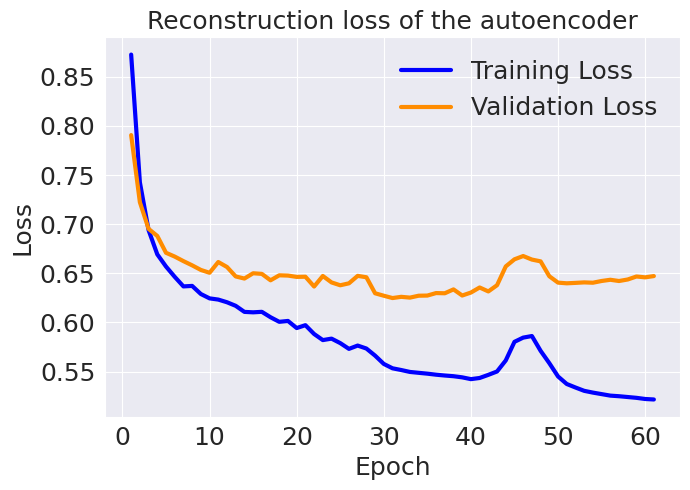

In [5]:
import pandas as pd
df = pd.read_csv('pretrain_log.csv')
fig= plt.figure(figsize=(7, 5))
plt.plot(df['epoch'],df['train_loss'], color='b',label='Training Loss', linewidth=3.0)
plt.plot(df['epoch'],df['val_loss'], color='darkorange',label='Validation Loss', linewidth=3.0)

plt.ylabel('Loss', fontsize= 18)
plt.xlabel('Epoch', fontsize= 18)
plt.title('Reconstruction loss of the autoencoder', fontsize= 18)
plt.yticks (fontsize= 18)
plt.xticks (fontsize= 18)

plt.legend(loc= 1, frameon= False, fontsize= 18)
plt.tight_layout()
plt.show ()
fig.savefig ( 'ReconstructionLoss.png', dpi= 100)

### Summary
Save, reload, and prepare the autoencoder for evaluation on the appropriate device.

In [6]:
# Save the model's state_dict
torch.save(model.state_dict(), 'autoencoder-model.pth')

# Re-import or re-define the Autoencoder class
autoencoder = Autoencoder()  # Instantiate the model
autoencoder.load_state_dict(torch.load('autoencoder-model.pth'))  # Load the state_dict

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

# Set the model to evaluation mode if you're testing or inferring
autoencoder.eval()


/tmp/ipykernel_2145543/434218544.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('autoencoder-model.pth'))  # Load the state_dict


Autoencoder(
  (conv1): Conv2d(1, 8, kernel_size=(7, 5), stride=(2, 2), padding=(3, 2))
  (conv2): Conv2d(8, 16, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=3072, bias=True)
  (fc3): Linear(in_features=3072, out_features=3072, bias=True)
  (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
  (conv_transpose2): ConvTranspose2d(32, 16, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
  (conv_transpose3): ConvTranspose2d(16, 8, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
  (conv_transpose4): ConvTranspose2d(8, 1, kernel_size=(7, 5), stride=(2, 2), padding=(3, 2)

### Summary
Convert the data into a tensor and add an additional dimension, often required for model input formatting (e.g., for channels in convolutional layers).

In [7]:
data_tensor = torch.tensor(data_file)  # Convert to PyTorch tensor
data_tensor = data_tensor.unsqueeze(1)  # Adds a dimension at position 1

data_tensor.shape

torch.Size([2390, 1, 96, 128])

### Autoencoder input-output visualization

1. **Autoencoder Inference**  
   Passes the `data_tensor` through the autoencoder to get the decoded (reconstructed) images: `decoded_imgs`.

2. **Plotting Setup**  
   Sets a range `s` to `e` for selecting a subset of data and defines `n` as the number of images to plot.

3. **Display Original and Reconstructed Images**  
   - For each image in the specified range, the code creates two subplots:
     - **Original Image**: Displays the original spectrogram (`data_file[i, :, :]`) using `librosa.display.specshow()`.
     - **Reconstructed Image**: Displays the reconstructed image (`decoded_imgs[i, 0, :, :]`) from the autoencoder.

   Both images are shown with a color bar, and axis labels are hidden for cleaner visualization.

4. **Display the Plot**  
   Finally, the plot is displayed using `plt.show()`.

### Summary
This code visualizes the original and reconstructed spectrograms for a subset of input data, comparing how well the autoencoder reconstructs the input.

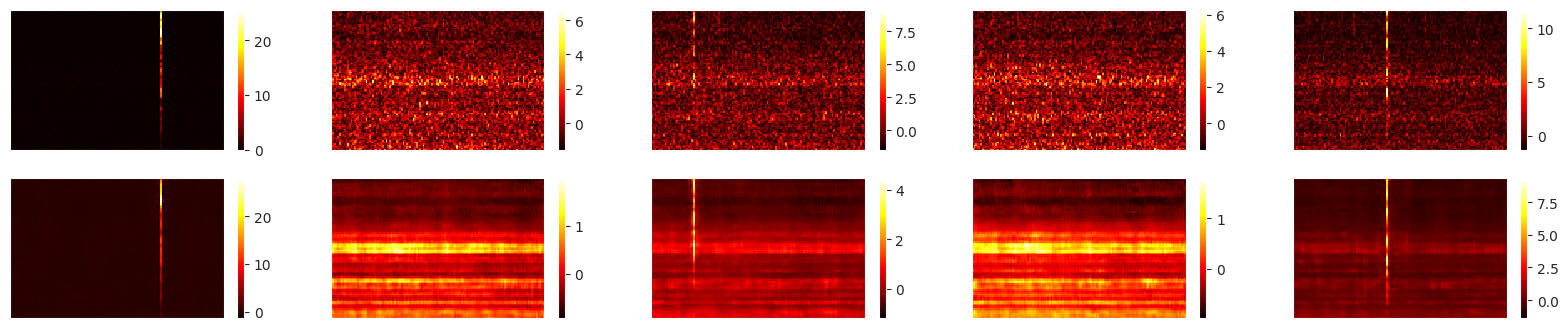

In [ ]:
decoded_imgs, _ = autoencoder(data_tensor.float().to(device))

import librosa
import librosa.display

s = 300
e= 305
n = e-s

plt.figure(figsize=(20, 4))
for i in range(s,e):
    
    # Display original
    ax = plt.subplot(2, n, i-s + 1)
    librosa.display.specshow(data_file[i,:,:], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i-s + 1 + n)
    librosa.display.specshow(decoded_imgs.cpu().detach().numpy()[i,0, :,:], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Kmeans clustering based on extracted features from the autoencoder

1. **Extract Features**  
   Passes `data_tensor` through the autoencoder to get the encoded features (`encoded_imgs`) and the decoded outputs (`decoded_imgs`).

2. **K-Means Clustering**  
   Applies K-Means clustering on the encoded features (`encoded_imgs`), specifying `n_clusters=1` to group the data into a single cluster. It uses 20 initializations (`n_init=20`) for better convergence and a fixed random seed for reproducibility.

3. **t-SNE Visualization**  
   - Uses t-SNE to reduce the dimensionality of the encoded features (`encoded_imgs`) to 2D for visualization.
   - The function `plotter()` generates a scatter plot of the 2D t-SNE projection, coloring the points by their predicted cluster label `y`.

4. **Plotting the Results**  
   The scatter plot is displayed using `plt.show()`, and a copy of the figure is saved as `'Tnse-km-n1'`.

### Summary
Perform K-Means clustering on the encoded features from the autoencoder and visualize the results using t-SNE, showing how the data points group based on the learned representations.

In [ ]:
decoded_imgs, encoded_imgs = autoencoder(data_tensor.float().to(device))

kmeans = KMeans(n_clusters=1, random_state=46, n_init=20).fit(encoded_imgs.cpu().detach().numpy())
y = kmeans.predict(encoded_imgs.cpu().detach().numpy())

# function to visualize the outputs of t-SNE
def plotter(S, y):
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    plt.scatter(S[y == 0, 0], S[y == 0, 1],color='navy', alpha=.5, lw=lw, s=100)
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tnse-km-n1', dpi= 100,bbox_inches = "tight")

    return f, ax

enc = encoded_imgs.cpu().detach().numpy()

from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
plotter(redu, y) 


# Determining optimal number of clusters

1. **Calinski-Harabasz Score Calculation**  
   Iterates over a range of cluster counts (`K = 2 to 15`) and for each `k`, it performs K-Means clustering on the encoded images (`encoded_imgs`).
   - The `calinski_harabasz_score()` is calculated for each clustering result, which measures how well-separated the clusters are.

2. **Plotting the Calinski-Harabasz Score**  
   - Plots the Calinski-Harabasz score against the number of clusters.
   - Adds a vertical line at `x=4` to indicate the optimal number of clusters, where the score begins to plateau (elbow point).

3. **Visualization**  
   The plot is displayed with `plt.show()` and saved as `'Calinski score.png'`.

### Summary
This code computes the Calinski-Harabasz score for different numbers of clusters in K-Means and visualizes it to identify the optimal number of clusters based on the elbow method.

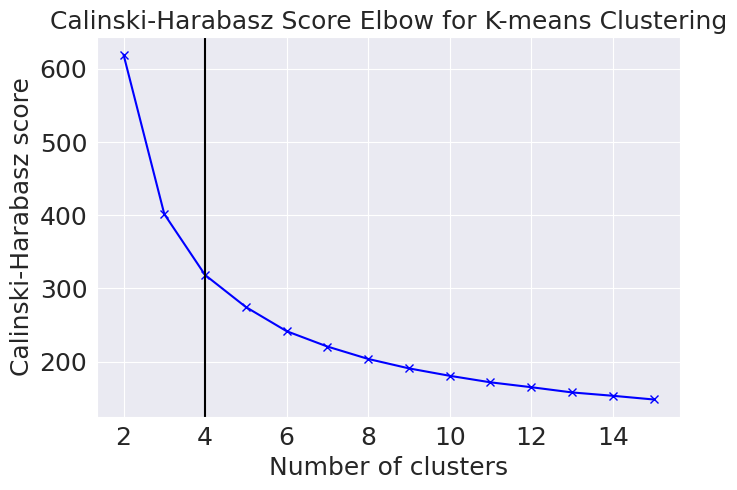

In [10]:
from sklearn.metrics import calinski_harabasz_score
cal = []
K = range(2,16)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20).fit(encoded_imgs.cpu().detach().numpy())
    labelskm = kmeans.predict(encoded_imgs.cpu().detach().numpy())
    cal.append(calinski_harabasz_score(encoded_imgs.cpu().detach().numpy(), labelskm))
fig= plt.figure(figsize=(7, 5))
plt.plot(K, cal, 'bx-')
plt.xlabel('Number of clusters',fontsize= 18)
plt.ylabel('Calinski-Harabasz score',fontsize= 18)
plt.title('Calinski-Harabasz Score Elbow for K-means Clustering',fontsize= 18)
plt.yticks (fontsize= 18)
plt.xticks (fontsize= 18)
plt.axvline(x = 4, color = 'black')
plt.tight_layout()
plt.show()
fig.savefig ( 'Calinski score.png', dpi=100)

# T-sne visualizations of seismic event clusters in feature domain after pretraining

1. **K-Means Clustering**  
   Performs K-Means clustering with 4 clusters (`n_clusters=4`) on the encoded images (`encoded_imgs`), and assigns each data point a cluster label `y`.

2. **t-SNE Dimensionality Reduction**  
   Uses t-SNE to reduce the encoded features (`encoded_imgs`) to 2D for visualization. The `TSNE(random_state=123)` transformation creates a 2D representation of the feature space.

3. **Visualization**  
   The `plotter()` function creates a scatter plot of the 2D t-SNE projection. Points are colored according to their K-Means cluster labels (`y`), and each cluster is labeled with its corresponding `target_names` (e.g., 'cluster 1', 'cluster 2', etc.).
   - The scatter plot is displayed and saved as `'Tnse-km-n4'`.

### Summary
Apply K-Means clustering to the encoded features from the autoencoder and visualize the resulting clusters using t-SNE, coloring and labeling the points according to their cluster membership.

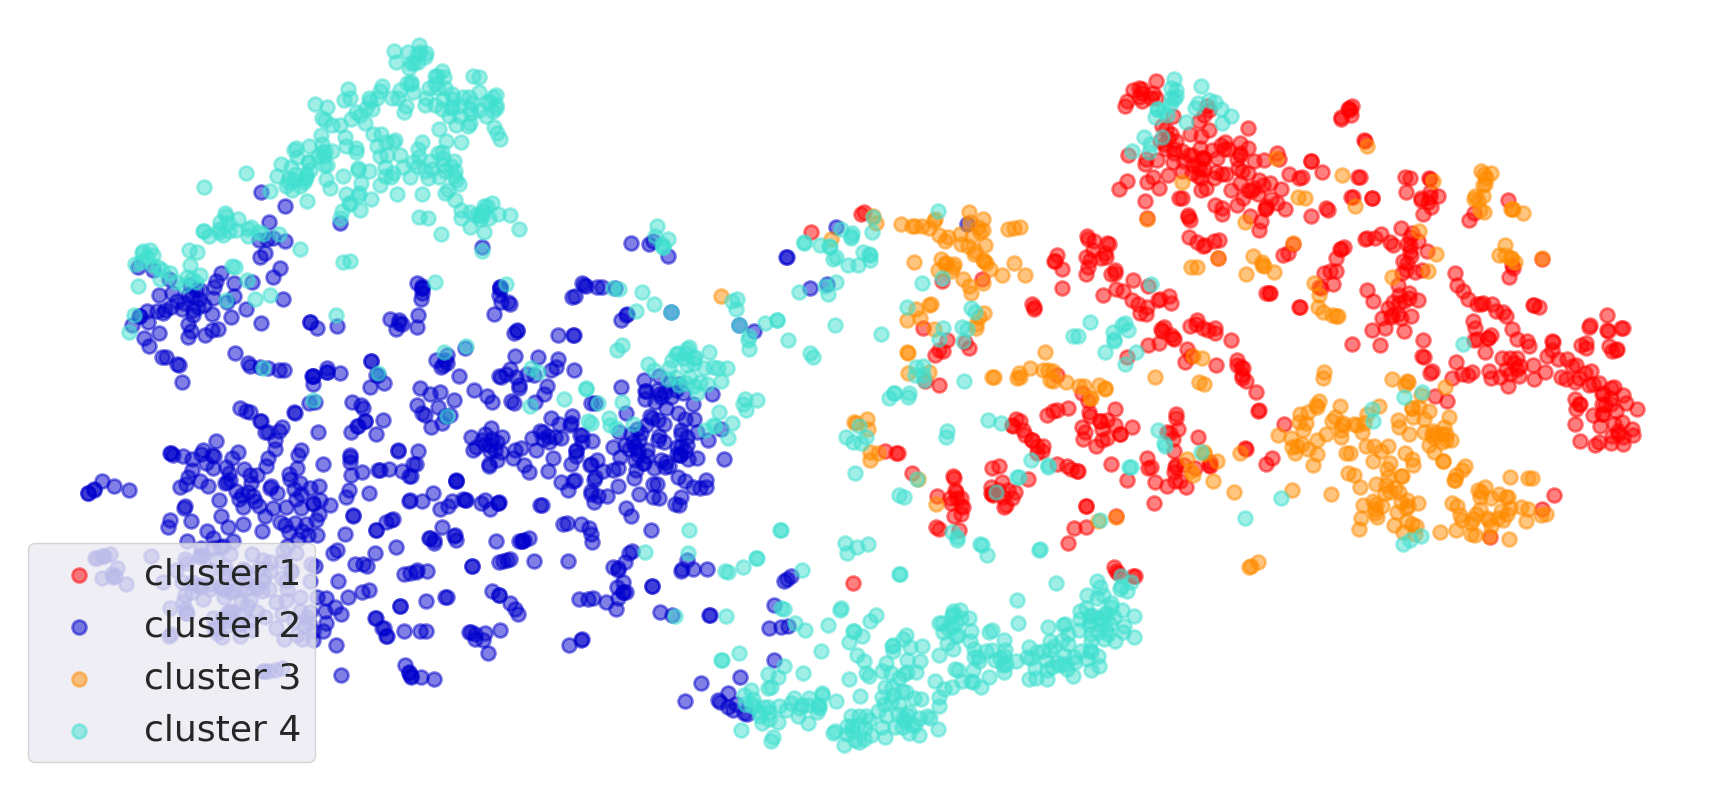

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [11]:
enc = encoded_imgs.cpu().detach().numpy()
kmeans = KMeans(n_clusters=4, random_state=46, n_init=20).fit(encoded_imgs.cpu().detach().numpy())
y = kmeans.predict(enc)

def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = [ 'red', 'mediumblue','darkorange','turquoise','lime', 'turquoise', 'darkorange','lawngreen', 'red', 'saddlebrown']
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [3,0, 1,2], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tnse-km-n4', dpi= 100,bbox_inches = "tight")

    return f, ax

enc = encoded_imgs.cpu().detach().numpy()
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4']
plotter(redu, y, target_names) 


# Loading the pre-trained model

1. **Loading Data and Pre-processing**  
   Converts `data_file` into a PyTorch tensor and adds an additional dimension at position 1 using `unsqueeze(1)`. The data is moved to the device (GPU or CPU as available).

2. **Setting Model to Evaluation Mode**  
   The model is set to evaluation mode using `autoencoder.eval()`. This ensures that layers like dropout or batch normalization behave differently during inference than during training.

3. **Hook Registration**  
   A custom function `get_layer_output_hook(name)` is defined to capture the output of each layer. This function is then registered as a forward hook for each layer in the autoencoder (skipping the first layer to focus on subsequent layers). Hooks are registered to store the outputs of each layer in a dictionary (`layer_outputs`).

4. **Forward Pass**  
   A forward pass is run with the `data_tensor` to pass the input through the model. During this pass, the hook functions capture the output of each layer.

5. **Display Layer Outputs**  
   The output shapes of each layer are printed, providing insight into how the data transforms as it passes through each layer of the autoencoder.

### Summary
Load the pre-trained autoencoder, process input data, and capture the output at each layer during the forward pass using hooks. Print the shapes of the outputs at each layer for inspection.

In [12]:
data_tensor = torch.tensor(data_file)  # Convert to PyTorch tensor
data_tensor = data_tensor.unsqueeze(1).to(device)  # Adds a dimension at position 1


# Assuming autoencoder and data_file are already defined
autoencoder.eval()  # Set to evaluation mode

# Define a dictionary to store layer outputs
layer_outputs = {}

# Function to create hooks for capturing the outputs
def get_layer_output_hook(name):
    def hook(module, input, output):
        layer_outputs[name] = output
    return hook

# Register hooks on each layer you want to capture (starting from layer 1 as in your example)
for idx, layer in enumerate(list(autoencoder.children())[1:], start=1):
    layer.register_forward_hook(get_layer_output_hook(f'layer_{idx}'))

# Run a forward pass with `data_file` to capture the outputs
with torch.no_grad():  # Disable gradient computation
    data = torch.tensor(data_tensor, dtype=torch.float32)  # Convert data_file to tensor
    autoencoder(data)  # Run data through the model to capture intermediate outputs

# Display the outputs
for name, output in layer_outputs.items():
    print(f"{name} output shape: {output.shape}")


layer_1 output shape: torch.Size([2390, 16, 24, 32])
layer_2 output shape: torch.Size([2390, 32, 12, 16])
layer_3 output shape: torch.Size([2390, 64, 6, 8])
layer_4 output shape: torch.Size([2390, 3072])
layer_5 output shape: torch.Size([2390, 24])
layer_6 output shape: torch.Size([2390, 3072])
layer_7 output shape: torch.Size([2390, 3072])
layer_8 output shape: torch.Size([2390, 32, 12, 16])
layer_9 output shape: torch.Size([2390, 16, 24, 32])
layer_10 output shape: torch.Size([2390, 8, 48, 64])
layer_11 output shape: torch.Size([2390, 1, 96, 128])


/tmp/ipykernel_2145543/174646368.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data_tensor, dtype=torch.float32)  # Convert data_file to tensor


# Integrating clustering layer into autoencoder bottleneck

#### 1. **Clustering Layer**
- **Purpose:** This *custom* `ClusteringLayer` applies a clustering algorithm (soft clustering based on the similarity to cluster centers) to the output of the autoencoder's encoder.
- **Initialization:** The cluster centers are initialized using Xavier uniform initialization. These are trainable parameters.
- **Forward Pass:** For each input, the layer computes a soft assignment (`q`) to each cluster. This is done using a distance measure between the input and the cluster centers, scaled by an alpha parameter to control the softness of the assignments. The soft assignments (`q`) are normalized to form probabilities for each cluster.

#### 2. **Clustered Autoencoder**
- **Purpose:** This class integrates the `ClusteringLayer` with an autoencoder. The `ClusteredAutoencoder` passes the encoder's output through the clustering layer and returns both the decoded output and the cluster assignments.
- **Forward Pass:** The autoencoder generates the decoded and encoded outputs. Then, the encoded representation is passed through the clustering layer to get cluster assignments.

#### 3. **KL-Divergence Loss Function**
- **Purpose:** A *custom* loss function (`kld_loss`) is used to measure the difference between the cluster assignment probabilities (`q`) and a target distribution (`p`). The target distribution (`p`) is computed using the square of the soft assignments (`q`) and normalized.
- **Loss Calculation:** The total loss is a combination of the reconstruction loss (mean squared error between the decoded output and input) and the clustering loss (KL divergence between `q` and `p`).

#### 4. **Training Loop**
- **Data Processing:** During training, the model processes batches of data, calculates the reconstruction loss and clustering loss, and backpropagates to update the model's weights. The optimizer is set up using Stochastic Gradient Descent (SGD).

#### 5. **Model Setup**
- **Device Setup:** The model is moved to the GPU (if available) using `model.to(device)`.
- **Dummy Input:** A dummy input is created to simulate a batch for model summary using `torchinfo`. This allows visualization of the model architecture.

#### 6. **Model Summary**
- **torchinfo:** A summary of the model architecture, including layer names, output shapes, and parameter counts, is printed using `summary()`.

### Summary
This code integrates a clustering layer into an autoencoder to perform clustering in the latent space, along with the reconstruction of inputs. It uses a soft clustering method based on the encoded features from the autoencoder. The training loop minimizes both reconstruction and clustering loss, and the model is visualized and summarized using `torchinfo`.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Set seed for reproducibility
seed = 46
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize Xavier initializer (same as GlorotUniform in TensorFlow)
initializer = nn.init.xavier_uniform_
n_clusters = 4 # Set desired number of clusters

# Define the clustering layer in PyTorch
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, input_dim, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        
        # Initialize the cluster centers
        self.clusters = nn.Parameter(torch.Tensor(n_clusters, input_dim))
        # Define cluster centers as a trainable parameter
        
        initializer(self.clusters)  # Xavier initialization

    def forward(self, inputs):
        
        print(inputs.shape)
        self.clusters = self.clusters.to(inputs.device)
        # Compute the soft assignment q
        q = 1.0 / (1.0 + (torch.sum((inputs.unsqueeze(1) - self.clusters) ** 2, dim=2) / self.alpha))
        q = q ** ((self.alpha + 1.0) / 2.0)
        q = q / torch.sum(q, dim=1, keepdim=True)  # Normalize to get probabilities per cluster
        return q

# Define the full model with the clustering layer on top of the autoencoder
class ClusteredAutoencoder(nn.Module):
    def __init__(self, autoencoder, n_clusters):
        super(ClusteredAutoencoder, self).__init__()
        self.autoencoder = autoencoder
        # Clustering layer connected to the output of the encoder
        self.clustering_layer = ClusteringLayer(n_clusters=n_clusters, input_dim=24)  # Match to `encoded` dimension

    def forward(self, x):
        decoded, encoded = self.autoencoder(x)
        q = self.clustering_layer(encoded)  # Cluster assignments
        return decoded, q  # Return both decoded output and cluster assignments

# Instantiate the models
n_clusters = 4  # Set desired number of clusters
model = ClusteredAutoencoder(autoencoder, n_clusters=n_clusters)

# Define the KL-divergence loss function
def kld_loss(q, p):
    return F.kl_div(q.log(), p, reduction='batchmean')

# Example optimizer setup
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop placeholder
def train(model, data_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for inputs, _ in data_loader:
            decoded, q = model(inputs)
            # Target distribution p, here using a sample softmax normalization of q as a placeholder
            p = (q ** 2) / torch.sum(q, dim=0)
            p = p / torch.sum(p, dim=1, keepdim=True)
            
            # Calculate the losses
            reconstruction_loss = F.mse_loss(decoded, inputs)
            clustering_loss = kld_loss(q, p)
            total_loss = 0.1 * clustering_loss + reconstruction_loss
            
            # Backward and optimize
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Ensure that the input data is on the same device (for example, random input)
dummy_input = torch.randn(1, 1, 96, 128).to(device)  # Simulate a batch of size 1

# Now use torchinfo for the summary
summary(model, input_size=(1, 1, 96, 128))

torch.Size([1, 24])


Layer (type:depth-idx)                   Output Shape              Param #
ClusteredAutoencoder                     [1, 1, 96, 128]           --
├─Autoencoder: 1-1                       [1, 1, 96, 128]           --
│    └─Conv2d: 2-1                       [1, 8, 48, 64]            288
│    └─Conv2d: 2-2                       [1, 16, 24, 32]           1,936
│    └─Conv2d: 2-3                       [1, 32, 12, 16]           7,712
│    └─Conv2d: 2-4                       [1, 64, 6, 8]             30,784
│    └─Flatten: 2-5                      [1, 3072]                 --
│    └─Linear: 2-6                       [1, 24]                   73,752
│    └─Linear: 2-7                       [1, 3072]                 76,800
│    └─Linear: 2-8                       [1, 3072]                 9,440,256
│    └─ConvTranspose2d: 2-9              [1, 32, 12, 16]           30,752
│    └─ConvTranspose2d: 2-10             [1, 16, 24, 32]           7,696
│    └─ConvTranspose2d: 2-11             [1, 8, 48, 

#### 1. **Preparing the Data**
- The code converts `data_file` into a PyTorch tensor using `torch.tensor(data_file)`. This is necessary to move the data into a form that can be used by the autoencoder model.
- It then adds an extra dimension to the data with `unsqueeze(1)`. This is important because models like autoencoders expect a specific shape of data, such as including a channels dimension for images or features for other data.
- Finally, the data is moved to the appropriate device (CPU or GPU) using `.to(device)`.

#### 2. **Setting Autoencoder to Evaluation Mode**
- The model is set to evaluation mode using `autoencoder.eval()`. This is done to ensure that any layers like dropout or batch normalization behave correctly during inference. During training, these layers work differently, so switching to evaluation mode is essential for correct predictions.

#### 3. **Capturing Layer Outputs with Hooks**
- The code defines a function, `get_layer_output_hook(name)`, which creates a hook for capturing the outputs of each layer during the forward pass.
- Hooks are registered on each layer of the autoencoder (excluding the first one) using `register_forward_hook`. These hooks store the outputs of the layers in the dictionary `layer_outputs` under the corresponding layer names.

#### 4. **Forward Pass to Capture Layer Outputs**
- A forward pass is performed through the model using `autoencoder(data)`. The data is passed through the autoencoder to capture the intermediate outputs of each layer.
- `torch.no_grad()` is used to ensure no gradients are calculated during this process, which is unnecessary for evaluation and helps reduce memory usage.

#### 5. **Displaying Captured Outputs**
- After running the forward pass, the outputs of each layer, stored in `layer_outputs`, are printed, displaying their shapes. This helps verify the size of the outputs at different layers and can be useful for debugging and understanding the model's behavior.

#### 6. **Clustering Setup (KMeans)**
- The number of clusters is set to 4 (`n_clusters = 4`) based on the results of the earlier evaluation.
- KMeans is then applied to the encoded output of the autoencoder (assumed to be stored in `layer_5`). KMeans is a clustering algorithm that groups data points based on their similarity. Here, it is used to find clusters in the encoded feature space of the autoencoder.
- `fit_predict()` is called on the encoded data to compute the cluster assignments (`y_pred`).

#### 7. **Initializing Clustering Layer with KMeans Centers**
- The cluster centers found by KMeans are used to initialize the parameters of the clustering layer in the autoencoder. This is done by extracting the cluster centers from KMeans and converting them into a PyTorch tensor.
- These cluster centers are directly assigned to the clustering layer’s `clusters` parameter using `model.clustering_layer.clusters.data = cluster_centers`.

#### 8. **Verifying the Initialization**
- The code prints the number of clusters in both the KMeans model and the clustering layer to ensure that the initialization was successful.
- This provides confirmation that the clustering layer's centers were initialized properly with the values found by KMeans.

### Summary
This code prepares the data, runs a forward pass through the autoencoder to capture layer outputs, and applies KMeans clustering to the encoded data. It initializes the clustering layer's parameters with the cluster centers found by KMeans, allowing the model to perform clustering in its learned latent space.

In [14]:
from sklearn.cluster import KMeans
import torch


# Assuming autoencoder and data_file are already defined
data_tensor = torch.tensor(data_file)  # Convert to PyTorch tensor
data_tensor = data_tensor.unsqueeze(1).to(device)  # Adds a dimension at position 1

autoencoder.eval()  # Set to evaluation mode

# Define a dictionary to store layer outputs
layer_outputs = {}

# Function to create hooks for capturing the outputs
def get_layer_output_hook(name):
    def hook(module, input, output):
        layer_outputs[name] = output
    return hook

# Register hooks on each layer you want to capture (starting from layer 1 as in your example)
for idx, layer in enumerate(list(autoencoder.children())[1:], start=1):
    layer.register_forward_hook(get_layer_output_hook(f'layer_{idx}'))

# Run a forward pass with `data_file` to capture the outputs
with torch.no_grad():  # Disable gradient computation
    data = data_tensor.float()  # Ensure data is in float32 format
    autoencoder(data)  # Run data through the model to capture intermediate outputs

# Display the outputs
for name, output in layer_outputs.items():
    print(f"{name} output shape: {output.shape}")
    
    

n_clusters = 4  # Define the number of clusters

# Step 1: Perform KMeans on the encoded output to initialize cluster centers
kmeans = KMeans(n_clusters=n_clusters, random_state=46, n_init=20)
encoded_output = layer_outputs['layer_5'].cpu().detach().numpy()  # Assuming this is the encoded output
y_pred = kmeans.fit_predict(encoded_output)
y_pred_last = np.copy(y_pred)

# Step 2: Set the KMeans cluster centers as initial weights in the clustering layer
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device = device)

# Assuming model.clustering_layer is the clustering layer in the PyTorch model
model.clustering_layer.clusters.data = cluster_centers  # Directly assign cluster centers

# Verify the initialization
print("Number of clusters in KMeans model:", kmeans.n_clusters)
print("Number of clusters in clustering layer:", model.clustering_layer.n_clusters)
print("Assigned KMeans cluster centers as initial weights in the clustering layer.")


layer_1 output shape: torch.Size([2390, 16, 24, 32])
layer_2 output shape: torch.Size([2390, 32, 12, 16])
layer_3 output shape: torch.Size([2390, 64, 6, 8])
layer_4 output shape: torch.Size([2390, 3072])
layer_5 output shape: torch.Size([2390, 24])
layer_6 output shape: torch.Size([2390, 3072])
layer_7 output shape: torch.Size([2390, 3072])
layer_8 output shape: torch.Size([2390, 32, 12, 16])
layer_9 output shape: torch.Size([2390, 16, 24, 32])
layer_10 output shape: torch.Size([2390, 8, 48, 64])
layer_11 output shape: torch.Size([2390, 1, 96, 128])


Number of clusters in KMeans model: 4
Number of clusters in clustering layer: 4
Assigned KMeans cluster centers as initial weights in the clustering layer.


In [ ]:
# display the model structure
model

ClusteredAutoencoder(
  (autoencoder): Autoencoder(
    (conv1): Conv2d(1, 8, kernel_size=(7, 5), stride=(2, 2), padding=(3, 2))
    (conv2): Conv2d(8, 16, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
    (conv3): Conv2d(16, 32, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
    (conv4): Conv2d(32, 64, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=3072, out_features=24, bias=True)
    (fc2): Linear(in_features=24, out_features=3072, bias=True)
    (fc3): Linear(in_features=3072, out_features=3072, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 16, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
    (conv_transpose3): ConvTranspose2d(16, 8, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
    (conv_transpose4): ConvTran

#### 1. **Decoding the Images**
- `decoded_imgs = model(data_tensor.float().to(device))[0]` is where the model is used to generate the reconstructed output from the input `data_tensor`.
- The model returns both the decoded and encoded outputs, but the first element `[0]` is selected, which corresponds to the decoded images.
- The `data_tensor` is moved to the correct device (CPU or GPU) using `.to(device)` and converted to `float` type to ensure it matches the model's expected input format.

#### 2. **Plotting Original and Reconstructed Spectrograms**
- The loop from `s=300` to `e=305` (a range of 5 values) is used to visualize a subset of the data. This allows for a comparison of the original and reconstructed spectrograms in a manageable way.
- `n = e - s` defines the number of spectrograms to be plotted.

#### 3. **Display Original Spectrograms**
- The `librosa.display.specshow` function is used to visualize the spectrogram of the original data (`data_file[i,:,:]`). 
- Each original spectrogram is displayed as a subplot in the first row of the plot grid.
- The `alpha=None` makes the image solid, and `cmap='hot'` specifies the color map used for the spectrogram (which is typically red-yellow for high values and black for low).
- The x and y axis ticks are hidden with `ax.get_xaxis().set_visible(False)` and `ax.get_yaxis().set_visible(False)` to focus on the visual aspect of the spectrogram.

#### 4. **Display Reconstructed Spectrograms**
- The second row of the plot grid is used for the reconstructed spectrograms, where the `decoded_imgs` tensor (the model's output) is used.
- Similar to the original display, `librosa.display.specshow` is used to visualize the reconstructed spectrogram for each of the indices in the selected range (`i` from 300 to 305).
- `decoded_imgs.cpu().detach().numpy()[i, 0, :, :]` retrieves the reconstructed image, detaches it from the computation graph, and moves it to the CPU before converting it to a NumPy array for visualization.

#### 5. **Plot Configuration**
- `plt.figure(figsize=(20, 4))` creates a large figure for the visualization, ensuring that the spectrograms are displayed clearly.
- `plt.colorbar()` adds a color bar next to each spectrogram to show the intensity scale.
- The loop ensures that both the original and reconstructed spectrograms are plotted side by side for each data index in the specified range.

#### 6. **Display the Plots**
- `plt.show()` is used to display the final figure with the spectrograms. The plot will show a side-by-side comparison of the original and the reconstructed spectrograms, providing a visual assessment of how well the model has reconstructed the input data.

### Summary
This code generates a visual comparison between the original and reconstructed spectrograms of the data. The original spectrograms from `data_file` are shown in the first row, and the corresponding reconstructed spectrograms from the autoencoder's output are shown in the second row, allowing for a visual evaluation of the model's performance on the given data.

torch.Size([2390, 24])


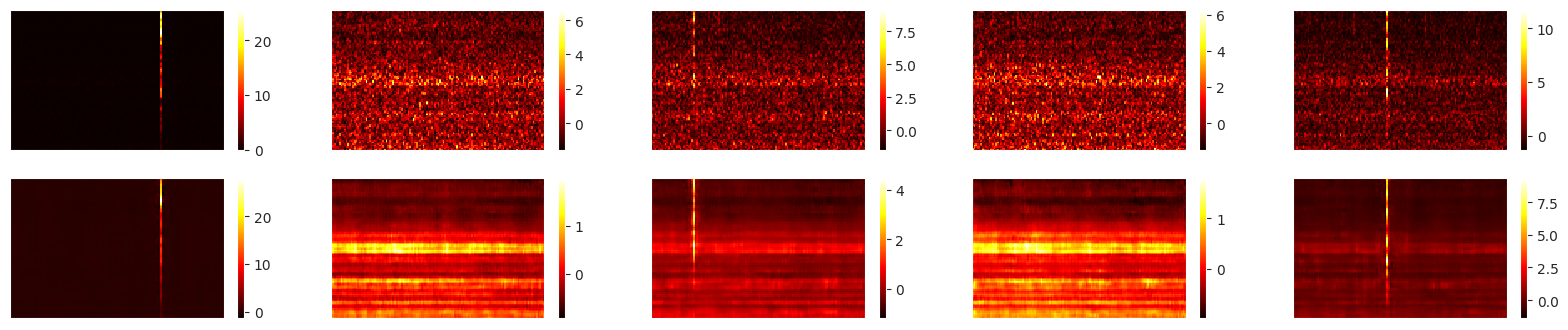

In [ ]:
decoded_imgs  = model(data_tensor.float().to(device))[0]

import librosa
import librosa.display

s = 300
e= 305
n = e-s

plt.figure(figsize=(20, 4))
for i in range(s,e):
    
    # Display original
    ax = plt.subplot(2, n, i-s + 1)
    librosa.display.specshow(data_file[i,:,:], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i-s + 1 + n)
    librosa.display.specshow(decoded_imgs.cpu().detach().numpy()[i,0, :,:], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Finetuning pre-trained model parameters

#### 1. **Setting Up the Model for Evaluation**
- `model.eval()` sets the model to evaluation mode. This ensures that any layers like dropout or batch normalization behave appropriately during inference or fine-tuning.

#### 2. **Fine-Tuning Parameters**
- **Batch Size:** `batch_size = 32` specifies the number of samples in each mini-batch used during fine-tuning.
- **Tolerance:** `tol = 0.0001` defines the tolerance for early stopping. If the change in cluster assignments between iterations is below this threshold, training will stop early.
- **Maximum Iterations:** `maxiter = 300` sets the maximum number of fine-tuning iterations.
- **Update Interval:** `update_interval = 200` specifies how often the target distribution will be updated during training.
- **Loss Initialization:** `loss_value = 0` initializes the loss value, which will be updated in each iteration.
- **Index Tracking:** `index = 0` starts the batch index at 0, which will be incremented for each mini-batch during training.

#### 3. **Data Preparation**
- The data is loaded into `data_tensor` as a PyTorch tensor, converted to `float32`, and unsqueezed to add an extra dimension. The data is then moved to the specified device (CPU or GPU).
  
#### 4. **Target Distribution Function**
- The `target_distribution(q)` function calculates the target distribution (`p`) used for clustering. This distribution is updated periodically.
- The function computes the squared soft assignments (`q**2`) and normalizes them to create a probability distribution. The normalization ensures the target distribution sums to 1 across all clusters.

#### 5. **Fine-Tuning Loop**
- **Iteration:** The loop runs for up to `maxiter` iterations. In each iteration:
  - **Updating Target Distribution:** If the current iteration is divisible by `update_interval`, the target distribution is updated.
    - A forward pass is performed through the model (with `torch.no_grad()` to disable gradient tracking).
    - The soft assignments `q` are obtained, and the target distribution `p` is calculated based on `q`.
    - The cluster assignments (`y_pred`) are determined by taking the `argmax` of `q`.
    - If the change in cluster assignments (`delta_label`) is below the `tol`, the loop stops early (indicating convergence).
  
#### 6. **Mini-Batch Training**
- **Batch Selection:** A mini-batch of data is selected from `data_tensor` based on the current `index`, using the defined `batch_size`. The target distribution `p` is also selected for the current batch.
- **Forward Pass:** The model performs a forward pass for the mini-batch, returning both the decoded output (`decoded`) and the soft cluster assignments (`q_batch`).
- **Loss Calculation:**
  - **Clustering Loss:** The clustering loss is computed using the Kullback-Leibler (KL) divergence between the predicted cluster assignments (`q_batch`) and the target distribution (`batch_p`). The `reduction="batchmean"` ensures the loss is averaged across the batch.
  - **Reconstruction Loss:** The reconstruction loss is calculated using Mean Squared Error (MSE) between the reconstructed data (`decoded`) and the original data (`batch_data`).
  - **Total Loss:** The total loss is a weighted sum of the clustering and reconstruction losses, with the clustering loss weighted by a factor of 0.1.
- **Backpropagation:** The gradients are calculated and backpropagated using `total_loss.backward()`, and the optimizer updates the model's parameters using `optimizer.step()`.

#### 7. **Updating Loss and Index**
- The loss value for the current iteration is stored in `loss_value`, and the `index` is updated for the next mini-batch. If the batch index exceeds the number of available batches, it wraps around to the beginning.

### Summary
This code fine-tunes a pre-trained model by periodically updating the clustering target distribution and adjusting model parameters through mini-batch training. The fine-tuning involves both a clustering loss (KL divergence) and a reconstruction loss (MSE), which are combined to optimize the model's parameters. The process includes early stopping based on the convergence of cluster assignments, allowing for more efficient training. The model is trained for a set number of iterations (`maxiter`), but the loop may stop early if the cluster assignments stabilize.

In [ ]:
#pip install torch
import torch
import numpy as np

model.eval()

# Parameters for fine-tuning
batch_size = 32
tol = 0.0001  # tolerance threshold for early stopping
loss_value = 0
index = 0
maxiter = 300
update_interval = 200
index_array = np.arange(data_file.shape[0])
y_pred_last = np.zeros(data_file.shape[0])

data_tensor = torch.tensor(data_file, dtype=torch.float32)
data_tensor = data_tensor.unsqueeze(1).to(device)  # Adds a dimension at position 1

# Define the target distribution function
def target_distribution(q):
    weight = q ** 2 / np.sum(q, axis=0)
    return (weight.T / np.sum(weight, axis=1)).T

# Fine-tuning loop
for ite in range(maxiter):
    print(f"Iteration: {ite}")
    
    # Update clustering target distribution periodically
    if ite % update_interval == 0:
        print("Updating target distribution")
        
        # Forward pass to get cluster assignments
        with torch.no_grad():
            
            
            _, q = model(data_tensor)
       
            q = q.cpu().numpy()  # Convert to numpy for further processing
        
        # Update the target distribution `p`
        p = target_distribution(q)
        y_pred = q.argmax(1)  # Get cluster assignments
        
        # Print loss and clustering information
        print(f"Iter {ite}: ; loss={round(loss_value, 5)}")

        # Check convergence criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        
        if ite > 0 and delta_label < tol:
            print(f"Convergence achieved: delta_label {delta_label} < tol {tol}")
            break
    
    # Mini-batch training
    start_idx = index * batch_size
    end_idx = min((index + 1) * batch_size, data_file.shape[0])
    idx = index_array[start_idx:end_idx]
    
    batch_data = data_tensor[idx]
    batch_p = torch.tensor(p[idx], dtype=torch.float32, device = device)

    # Zero gradients, forward pass, compute loss, backward pass, and update
    optimizer.zero_grad()
    decoded, q_batch = model(batch_data)
    clustering_loss = F.kl_div(q_batch.log(), batch_p, reduction="batchmean")
    reconstruction_loss = F.mse_loss(decoded, batch_data)
    total_loss = clustering_loss * 0.1 + reconstruction_loss
    total_loss.backward()
    optimizer.step()

    # Update loss and index for next iteration
    loss_value = total_loss.item()
    index = (index + 1) % (data_file.shape[0] // batch_size)


# T-sne visualizations of seismic event clusters in feature domain after finetuning

#### 1. **Setting the Model to Evaluation Mode**
- `autoencoder.eval()` sets the model to evaluation mode, which disables any layers (e.g., dropout, batch normalization) that behave differently during training.

#### 2. **Capturing Layer Outputs Using Hooks**
- **Layer Output Dictionary:** `layer_outputs` is initialized as an empty dictionary to store the outputs of the layers.
- **Hook Function:** `get_layer_output_hook(name)` is a function that registers a hook for capturing the output of each layer. The hook will save the output of each layer in the `layer_outputs` dictionary, using the layer's name as the key.
  
#### 3. **Registering Hooks on Layers**
- **Enumerating Layers:** The `for` loop registers the hooks on all layers of the autoencoder model starting from the second layer (skipping the input layer) using `autoencoder.children()`. The hooks capture the output of each layer during a forward pass.

#### 4. **Forward Pass to Capture Outputs**
- The `with torch.no_grad()` block disables gradient computation during the forward pass to save memory and computation since we're only interested in the output, not backpropagation.
- The `autoencoder(data)` line runs the data through the model to capture the intermediate outputs, which are stored in the `layer_outputs` dictionary.

#### 5. **Setting Up T-SNE Visualization**
- **Target Labels (`y`):** The predicted cluster labels (`y_pred`) are assigned to `y` to be used in visualization.
- **`plotter` Function:** This function takes the T-SNE transformed data (`S`), the target labels (`y`), and the names of the target classes (`target_names`) to create a scatter plot. 
  - The plot uses a predefined set of colors for each cluster and labels the points with the corresponding class name.
  - The scatter plot is created using `plt.scatter`, and the plot is displayed and saved as `'Tsne-km-n4-ft.png'`.

#### 6. **Extracting Encoded Features and Performing T-SNE**
- **Encoded Output:** The output from `layer_5` is extracted from `layer_outputs` and converted to a NumPy array (`enc`).
- **T-SNE Transformation:** The encoded data (`enc`) is transformed into a 2D representation using T-SNE (`TSNE(random_state=123).fit_transform(enc)`). T-SNE is a dimensionality reduction technique that is well-suited for visualizing high-dimensional data in 2D.
  
#### 7. **Plotting the T-SNE Results**
- **Target Names:** `target_names` defines the labels for the clusters, which correspond to different seismic event types.
- The `plotter` function is called with the T-SNE results (`redu`), predicted labels (`y`), and target names to generate the visualization.

#### 8. **Displaying and Saving the Plot**
- The plot is displayed using `plt.show()` and saved to a file `'Tsne-km-n4-ft.png'`.

### Summary
This code fine-tunes the autoencoder model and then visualizes the clustering of seismic event types in the feature domain using T-SNE. The intermediate outputs from the model are captured using hooks, and the encoded features are used for T-SNE dimensionality reduction. The resulting 2D visualization shows the clustering of different seismic events, with the clusters labeled and color-coded. The plot is displayed and saved for later inspection.

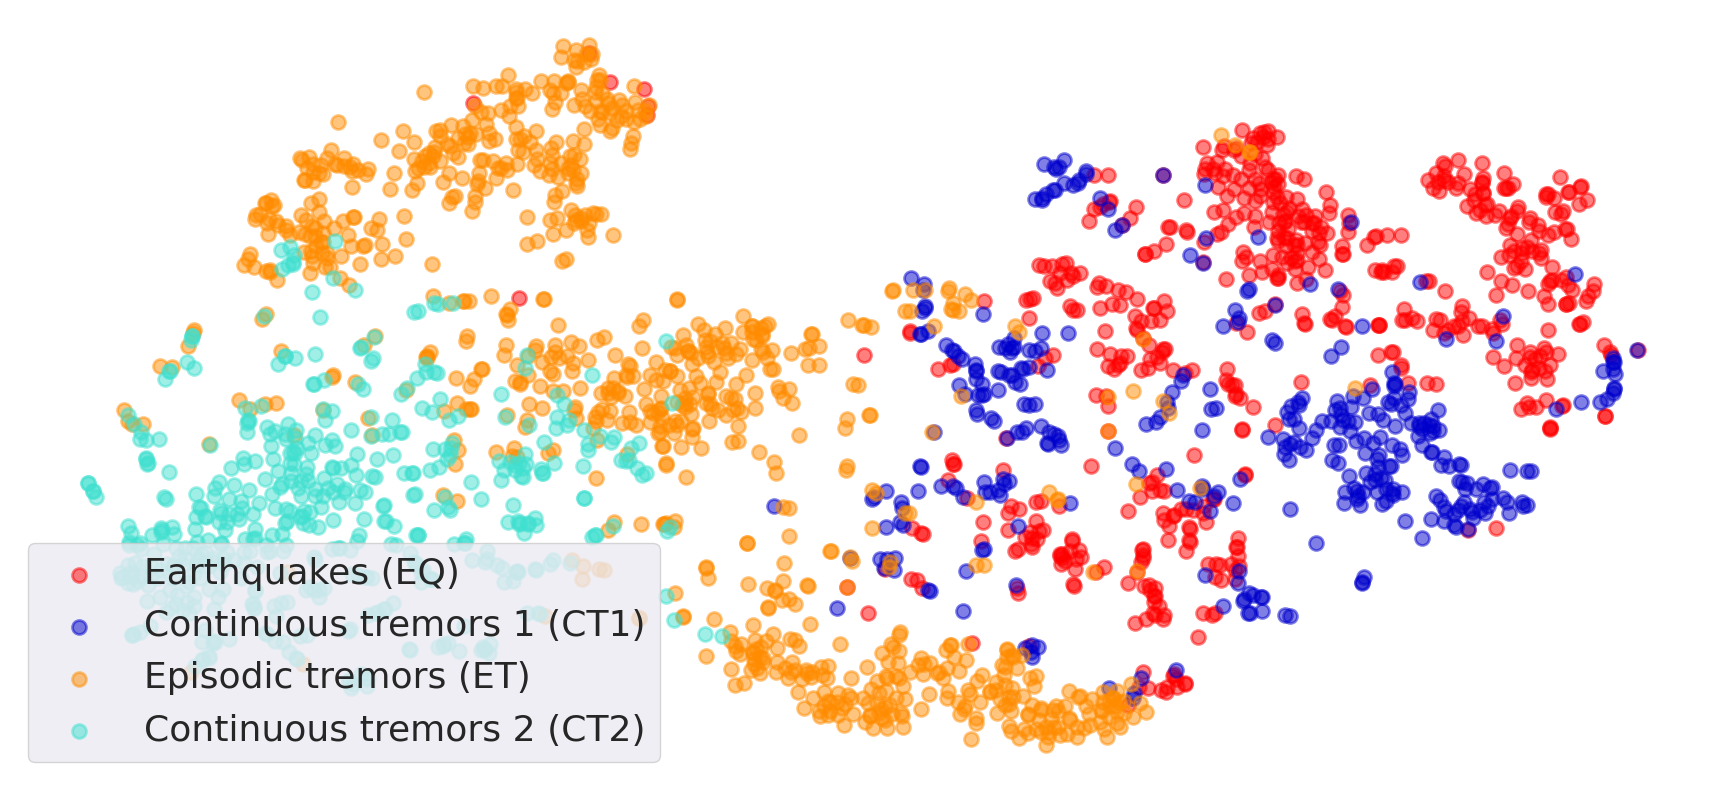

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [18]:
autoencoder.eval()  # Set to evaluation mode

# Define a dictionary to store layer outputs
layer_outputs = {}

# Function to create hooks for capturing the outputs
def get_layer_output_hook(name):
    def hook(module, input, output):
        layer_outputs[name] = output
    return hook

# Register hooks on each layer you want to capture (starting from layer 1 as in your example)
for idx, layer in enumerate(list(autoencoder.children())[1:], start=1):
    layer.register_forward_hook(get_layer_output_hook(f'layer_{idx}'))

# Run a forward pass with `data_file` to capture the outputs
with torch.no_grad():  # Disable gradient computation
    data = data_tensor.float()  # Ensure data is in float32 format
    autoencoder(data)  # Run data through the model to capture intermediate outputs

y=y_pred

def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['red', 'mediumblue','darkorange','turquoise', 'lawngreen', 'red', 'saddlebrown']
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [3,0, 1,2], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=0.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tsne-km-n4-ft.png', dpi= 100,bbox_inches = "tight")
    
    return f, ax

enc = layer_outputs['layer_5'].cpu().detach().numpy()
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = [ 'Earthquakes (EQ)','Continuous tremors 1 (CT1)', 'Episodic tremors (ET)', 'Continuous tremors 2 (CT2)' ]
plotter(redu, y, target_names) 


#### 1. **Saving the Cluster Labels**
- `np.savetxt('km-n4-ft.txt', y, fmt='%i', delimiter=',')` saves the cluster labels (`y`) to a text file `'km-n4-ft.txt'`. The labels are saved as integers, with each label separated by a comma.

#### 2. **Reading the Saved File**
- **Opening the File:** `with open('km-n4-ft.txt', 'r') as file` opens the previously saved file in read mode.
- **Reading the Content:** `filedata = file.read()` reads the entire content of the file into the variable `filedata`.

#### 3. **Replacing Cluster Labels**
- The code replaces the cluster numbers in the file content with new labels. This is done using the `replace` method on `filedata`:
  - `'3'` is replaced with `'data_file'` (a placeholder for the first replacement).
  - `'2'` is replaced with `'3'`.
  - `'1'` is replaced with `'2'`.
  - `'0'` is replaced with `'1'`.
  - Finally, `'data_file'` is replaced with `'0'` to complete the remapping.
  
  This process reorders the cluster labels for a more aesthetically pleasing or consistent representation.

#### 4. **Writing the Modified Labels Back to the File**
- After replacing the cluster numbers, `with open('km-n4-ft.txt', 'w') as file` opens the same file in write mode.
- **Writing the Modified Data:** `file.write(filedata)` writes the modified content back to the file, effectively updating the cluster labels.

### Summary
This code snippet saves the cluster labels to a file, modifies the cluster numbers for a more readable order, and writes the updated labels back to the file. The remapping of cluster numbers is done using string replacement, and the final labels are saved in the file `'km-n4-ft.txt'`.

In [19]:
### Save the labels
np.savetxt('km-n4-ft.txt', y, fmt='%i', delimiter=',')

# Change the order of the cluster numbers (just for a nice representation)

with open('km-n4-ft.txt', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('3', 'data_file')
filedata = filedata.replace('2', '3')
filedata = filedata.replace('1', '2')
filedata = filedata.replace('0', '1')
filedata = filedata.replace('data_file', '0')

# Re-write the output
with open('km-n4-ft.txt', 'w') as file:
  file.write(filedata)

### Visualizing cluster changes across time

#### 1. **Loading Cluster Labels**
- `y = np.loadtxt('km-n4-ft.txt')` loads the cluster labels from the file `'km-n4-ft.txt'` into the variable `y`.

#### 2. **Setting up the Plot**
- **Figure and Axes:** `fig = plt.figure(figsize=(18, 4))` creates a figure with a size of 18x4 inches. `ax = fig.add_subplot()` adds a single subplot to the figure.
- **x-axis Data:** `x1 = list(range(0, 2390))` creates a list of numbers from 0 to 2389, which will represent the time (or data points) on the x-axis.

#### 3. **Defining Colors for Clusters**
- **Color Palette:** `colors = ['red', 'mediumblue', 'darkorange', 'turquoise']` defines the colors for the four clusters.
- **Colormap:** `cmap = LinearSegmentedColormap.from_list(cmap_name, colors)` creates a custom colormap (`cmap`) from the defined color list.

#### 4. **Plotting the Data**
- `ax.scatter(x1, y, c=y, cmap=cmap, s=30, alpha=0.2)` creates a scatter plot:
  - `x1` represents the x-axis (data points).
  - `y` represents the cluster labels.
  - `c=y` uses the cluster labels to color the points.
  - `cmap=cmap` applies the custom colormap.
  - `s=30` sets the size of the points.
  - `alpha=0.2` sets the transparency of the points to 20%.

#### 5. **Customizing the y-axis**
- `ax.set_yticks([0, 1, 2, 3])` sets the y-axis ticks to the four clusters.
- `ax.set_yticklabels(['EQ', 'CT1', 'ET', 'CT2'], fontsize=18)` assigns labels to the ticks, representing the cluster types (e.g., 'EQ' for Earthquakes).

#### 6. **Customizing the x-axis**
- `ax.set_xticks([0, 175, 417, 708, 996, 1117, 1425, 1782, 2142, 2390])` sets the x-axis ticks to specific data points.
- `ax.set_xticklabels(['12 March', '19 March', '30 March', '15 April', '27 April', '2 May', '15 May', '30 May', '14 June', '24 June'], fontsize=16)` labels the x-axis with corresponding dates.
  
#### 7. **Adding Vertical Lines**
- `ax.axvline(x=174, linewidth=4, color='black')`, `ax.axvline(x=996, linewidth=4, color='black')`, and `ax.axvline(x=2127, linewidth=4, color='black')` add vertical lines at the specified x positions. These lines are used to highlight specific dates or events.

#### 8. **Setting the x-axis Limits**
- `plt.xlim(0, 2390)` sets the x-axis range from 0 to 2390 (the length of `x1`).

#### 9. **Saving the Figure**
- `fig.savefig('Temporal Cluster Changes.png', dpi=100)` saves the figure as a PNG file with a resolution of 100 DPI.

### Summary
This code visualizes the changes in cluster labels over time by plotting them as a scatter plot. It uses a custom colormap and labels the x-axis with dates, while also adding vertical lines to highlight important events. The result is saved as a PNG image called `'Temporal Cluster Changes.png'`.

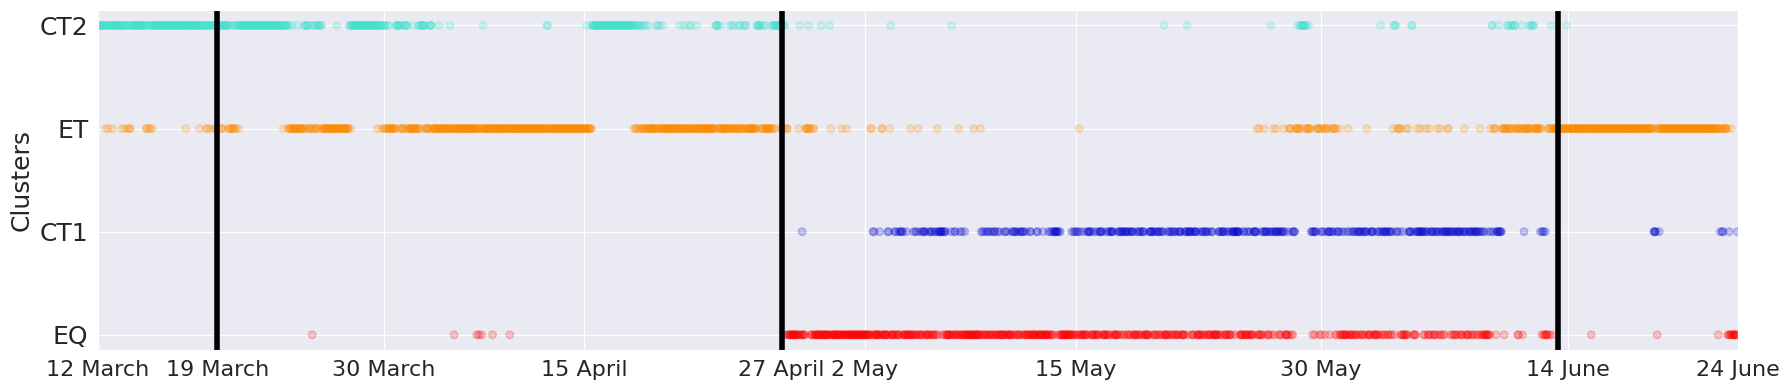

In [20]:
from matplotlib.colors import LinearSegmentedColormap

y= np.loadtxt ('km-n4-ft.txt')
fig= plt.figure(figsize=(18, 4))
ax = fig.add_subplot()
x1=list(range(0,2390))
colors = ['red', 'mediumblue','darkorange','turquoise']
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
ax.scatter (x1, y, c=y, cmap=cmap, s= 30, alpha=0.2)
ax.set_yticks ([0, 1, 2,3])
ax.set_yticklabels (['EQ','CT1', 'ET','CT2'], fontsize=18)
plt.ylabel('Clusters', fontsize= 18)

ax.set_xticks ([0,175,417,708,996,1117,1425,1782,2142,2390])
ax.set_xticklabels (['12 March','19 March','30 March','15 April','27 April','2 May','15 May','30 May','14 June','24 June'], fontsize=16)
ax.axvline (x=174, linewidth=4, color='black')
ax.axvline (x=996, linewidth=4, color='black')
ax.axvline (x=2127, linewidth=4, color='black')

plt.xlim (0,2390)
#plt.xlim (980,1020)
plt.tight_layout()
fig.savefig ( 'Temporal Cluster Changes.png', dpi= 100)

# Cluster-wise autoencoder input-output visualization

In [24]:
decoded_imgs[43,:,:,:].shape

(1, 96, 128)

#### 1. **Input Data Setup**
- **Decoded Image Generation:** 
  - `decoded_imgs, _ = autoencoder(data_tensor.float().to(device))` runs the autoencoder on the input data (`data_tensor`) to generate the decoded images.
  - `decoded_imgs = decoded_imgs.cpu().detach().numpy()` moves the decoded images back to the CPU and converts them to a NumPy array for visualization.

#### 2. **Setting Up the Figure and Grid**
- **Figure and Subplots:**
  - `fig = plt.figure(figsize=(15, 5))` creates a figure with the dimensions 15x5 inches.
  - `spec = gridspec.GridSpec(2, 3)` defines a 2x3 grid layout for the subplots.

#### 3. **Visualization of Original Data and Decoded Outputs**
- **Subplot 1 (`ax1`) - Original Data (Cluster EQ):**
  - `librosa.display.specshow(data_file[43, :, :], alpha=None, cmap='hot', antialiased=True, y_axis='linear', sr=8, vmin=-1, vmax=10)` displays the spectrogram of the original input data for cluster EQ (index 43) in the first subplot.
  - `cbar = plt.colorbar(pad=0.03)` adds a colorbar to the plot for the intensity of the spectrogram.
  - The `yticks` and `ylabel` configurations ensure the y-axis labels represent frequency and are properly formatted.

- **Subplot 2 (`ax2`) - Another Original Data (Cluster EQ):**
  - `librosa.display.specshow(data_file[44, :, :], alpha=None, cmap='hot', antialiased=True, y_axis='linear', sr=8, vmin=-1, vmax=10)` displays the spectrogram of the original data for cluster EQ (index 44).
  - The y-ticks are hidden to focus on the spectrogram’s features.

- **Subplot 3 (`ax3`) - Another Original Data (Cluster EQ):**
  - Similar to `ax2`, this displays the spectrogram for index 45, with identical colorbar and formatting.

- **Subplot 4 (`ax4`) - Decoded Data (Cluster EQ):**
  - `librosa.display.specshow(decoded_imgs[43, 0, :, :], alpha=None, cmap='hot', antialiased=True, y_axis='linear', sr=8, vmin=-1, vmax=10)` displays the spectrogram of the decoded data for the same index (43) but now using the model's output.
  - It also configures the x-ticks and y-ticks with labels, focusing on the frequency and time axes.

- **Subplot 5 (`ax5`) - Decoded Data (Cluster EQ):**
  - Similar to `ax4`, this displays the decoded data for index 44, with formatting to show time axis labels.

- **Subplot 6 (`ax6`) - Decoded Data (Cluster EQ):**
  - Similar to the previous decoded data visualizations, this shows the spectrogram for index 45.

#### 4. **Additional Plot Customization**
- **Tight Layout:** `plt.tight_layout()` ensures that subplots are neatly arranged without overlap.
- **Saving the Figure:** `plt.savefig('In&out-EQ.png', dpi=100, bbox_inches='tight')` saves the figure as a PNG file with 100 DPI resolution.

#### 5. **Display the Plot**
- `plt.show()` displays the final plot in the output window.

### Summary
This code visualizes the input-output relationships of a cluster from the autoencoder’s perspective. The first row of subplots shows the original spectrograms of data points, and the second row shows the corresponding decoded outputs after passing through the autoencoder. Each subplot is configured with proper axis labels for frequency and time. The final figure is saved as `'In&out-EQ.png'`.

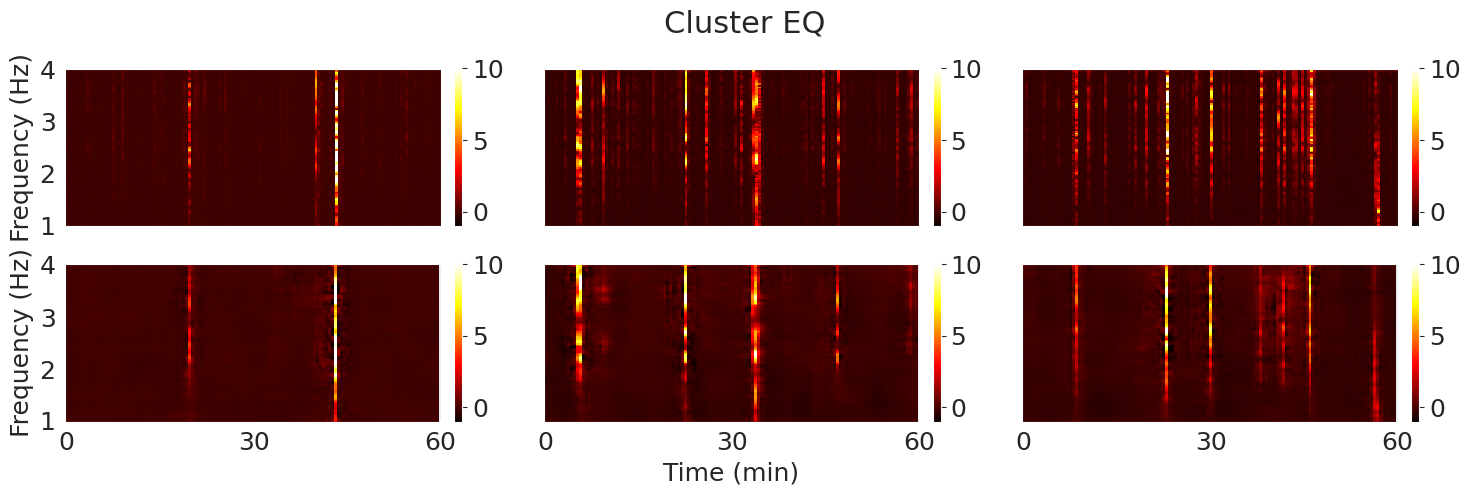

In [26]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec


decoded_imgs, _ = autoencoder(data_tensor.float().to(device))
decoded_imgs = decoded_imgs.cpu().detach().numpy()

fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(data_file[43,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(data_file[44,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax2.set(ylabel=None)

fig.suptitle ('Cluster EQ', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(data_file[45,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[43,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[44,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 18)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize=18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[45,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks ([])
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-EQ.png', dpi=100, bbox_inches = "tight")
plt.show()

#### 1. **Input Data Setup**
- **Decoded Image Generation:** 
  - `decoded_imgs, _ = autoencoder(data_tensor.float().to(device))` generates decoded images using the autoencoder model. The decoded images are then detached from the computation graph and transferred to a NumPy array.

#### 2. **Setting Up the Figure and Grid**
- **Figure and Subplots:**
  - `fig = plt.figure(figsize=(15, 5))` creates a figure of size 15x5 inches.
  - `spec = gridspec.GridSpec(2, 3)` sets up a 2x3 grid for the subplots, with 2 rows and 3 columns.

#### 3. **Visualization of Original Data and Decoded Outputs for Cluster CT1**
- **Subplot 1 (`ax1`) - Original Data (Cluster CT1):**
  - `librosa.display.specshow(data_file[353, :, :], alpha=None, cmap='hot', antialiased=True, y_axis='linear', sr=8, vmin=-1, vmax=10)` displays the spectrogram of the original data for cluster CT1 (index 353) in the first subplot.
  - A colorbar is added with `cbar = plt.colorbar(pad=0.03)` and y-ticks are configured to represent frequency values.

- **Subplot 2 (`ax2`) - Another Original Data (Cluster CT1):**
  - Similar to `ax1`, it displays the spectrogram for the data at index 354, with y-ticks showing frequency values.

- **Subplot 3 (`ax3`) - Another Original Data (Cluster CT1):**
  - Similar to the previous subplots, this displays the spectrogram for index 355.

- **Subplot 4 (`ax4`) - Decoded Data (Cluster CT1):**
  - `librosa.display.specshow(decoded_imgs[353, 0, :, :], alpha=None, cmap='hot', antialiased=True, y_axis='linear', sr=8, vmin=-1, vmax=10)` displays the spectrogram of the decoded data for index 353 from the autoencoder output.
  - Frequency and time labels are configured for this plot with `xticks` and `yticks` to display labels.

- **Subplot 5 (`ax5`) - Decoded Data (Cluster CT1):**
  - Similar to `ax4`, this displays the decoded data for index 354, with time and frequency labels configured.

- **Subplot 6 (`ax6`) - Decoded Data (Cluster CT1):**
  - Similar to `ax4` and `ax5`, this shows the decoded data for index 355.

#### 4. **Additional Plot Customization**
- **Tight Layout:** `plt.tight_layout()` adjusts the layout to prevent overlap of subplots.
- **Saving the Figure:** `plt.savefig('In&out-CT1.png', dpi=100)` saves the plot as a PNG file with a resolution of 100 DPI.

#### 5. **Display the Plot**
- `plt.show()` displays the figure.

### Summary
This code visualizes the original and decoded (autoencoder output) spectrograms for data points from cluster CT1. Each row of subplots compares the original and decoded spectrograms for the selected indices (353, 354, and 355). The plots are neatly arranged and saved as `'In&out-CT1.png'`.

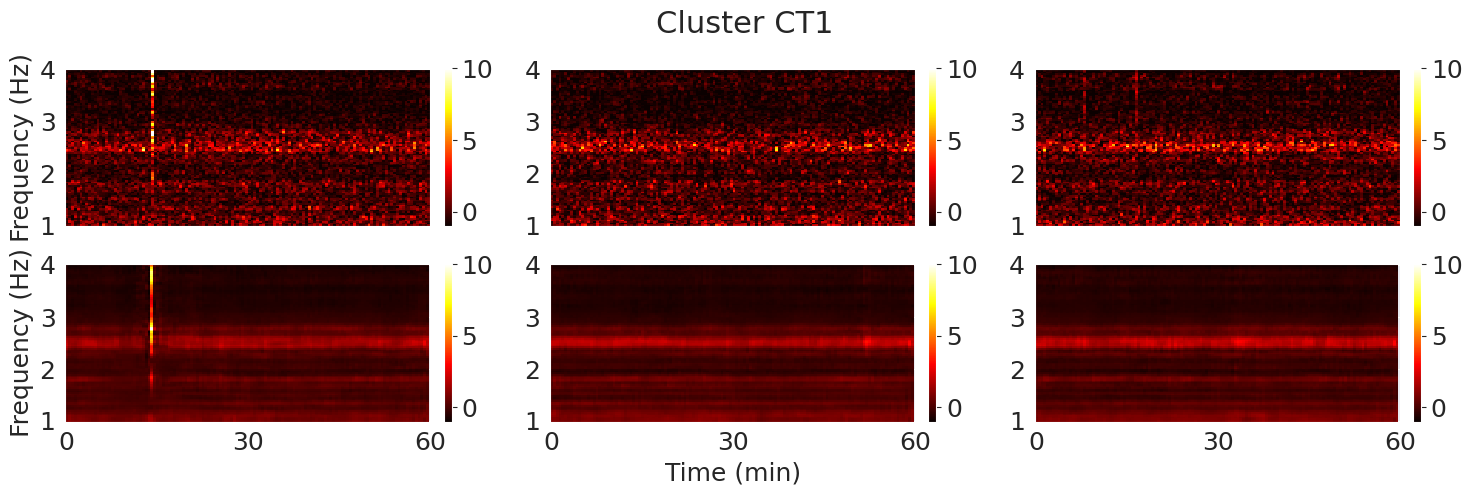

In [27]:
fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(data_file[353,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(data_file[354,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax2.set(ylabel=None)

fig.suptitle ('Cluster CT1', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(data_file[355,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[353,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[354,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 18)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[355,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-CT1.png', dpi=100)
plt.show()

#### 1. **Input Data Setup**
- **Decoded Image Generation:** 
  - `decoded_imgs, _ = autoencoder(data_tensor.float().to(device))` generates decoded images using the autoencoder model. The decoded images are then detached from the computation graph and transferred to a NumPy array.

#### 2. **Setting Up the Figure and Grid**
- **Figure and Subplots:**
  - `fig = plt.figure(figsize=(15, 5))` creates a figure of size 15x5 inches.
  - `spec = gridspec.GridSpec(2, 3)` sets up a 2x3 grid for the subplots, with 2 rows and 3 columns.

#### 3. **Visualization of Original Data and Decoded Outputs for Cluster ET**
- **Subplot 1 (`ax1`) - Original Data (Cluster ET):**
  - `librosa.display.specshow(data_file[1169, :, :], alpha=None, cmap='hot', antialiased=True, y_axis='linear', sr=8, vmin=-1, vmax=10)` displays the spectrogram of the original data for cluster ET (index 1169) in the first subplot.
  - A colorbar is added with `cbar = plt.colorbar(pad=0.03)` and y-ticks are configured to represent frequency values.

- **Subplot 2 (`ax2`) - Another Original Data (Cluster ET):**
  - Similar to `ax1`, it displays the spectrogram for the data at index 1170, with y-ticks showing frequency values.

- **Subplot 3 (`ax3`) - Another Original Data (Cluster ET):**
  - Similar to the previous subplots, this displays the spectrogram for index 1171.

- **Subplot 4 (`ax4`) - Decoded Data (Cluster ET):**
  - `librosa.display.specshow(decoded_imgs[1169, 0, :, :], alpha=None, cmap='hot', antialiased=True, y_axis='linear', sr=8, vmin=-1, vmax=10)` displays the spectrogram of the decoded data for index 1169 from the autoencoder output.
  - Frequency and time labels are configured for this plot with `xticks` and `yticks` to display labels.

- **Subplot 5 (`ax5`) - Decoded Data (Cluster ET):**
  - Similar to `ax4`, this displays the decoded data for index 1170, with time and frequency labels configured.

- **Subplot 6 (`ax6`) - Decoded Data (Cluster ET):**
  - Similar to `ax4` and `ax5`, this shows the decoded data for index 1171.

#### 4. **Additional Plot Customization**
- **Tight Layout:** `plt.tight_layout()` adjusts the layout to prevent overlap of subplots.
- **Saving the Figure:** `plt.savefig('In&out-ET.png', dpi=100)` saves the plot as a PNG file with a resolution of 100 DPI.

#### 5. **Display the Plot**
- `plt.show()` displays the figure.

### Summary
This code visualizes the original and decoded (autoencoder output) spectrograms for data points from cluster ET. Each row of subplots compares the original and decoded spectrograms for the selected indices (1169, 1170, and 1171). The plots are neatly arranged and saved as `'In&out-ET.png'`.

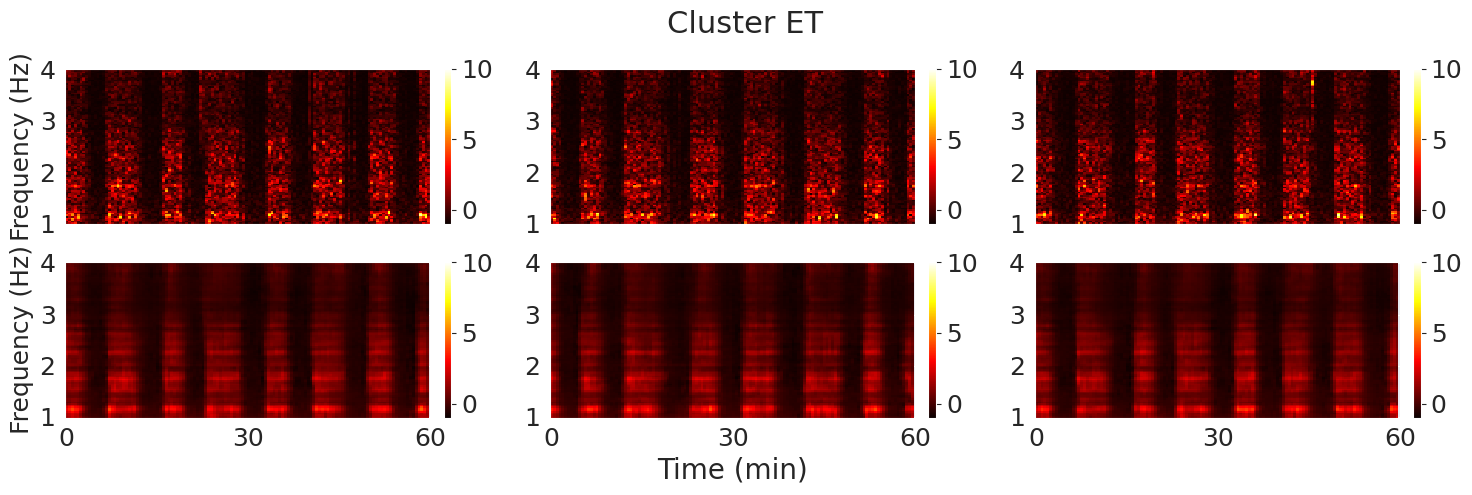

In [28]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec


fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(data_file[1169,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(data_file[1170,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax2.set(ylabel=None)

fig.suptitle ('Cluster ET', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(data_file[1171,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[1169,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[1170,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 20)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[1171,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-ET.png', dpi=100)
plt.show()

#### 1. **Input Data Setup**
- **Decoded Image Generation:** 
  - `decoded_imgs, _ = autoencoder(data_tensor.float().to(device))` generates decoded images using the autoencoder model. The decoded images are then detached from the computation graph and transferred to a NumPy array.

#### 2. **Setting Up the Figure and Grid**
- **Figure and Subplots:**
  - `fig = plt.figure(figsize=(15, 5))` creates a figure of size 15x5 inches.
  - `spec = gridspec.GridSpec(2, 3)` sets up a 2x3 grid for the subplots, with 2 rows and 3 columns.

#### 3. **Visualization of Original Data and Decoded Outputs for Cluster CT2**
- **Subplot 1 (`ax1`) - Original Data (Cluster CT2):**
  - `librosa.display.specshow(data_file[2342, :, :], alpha=None, cmap='hot', antialiased=True, y_axis='linear', sr=8, vmin=-1, vmax=10)` displays the spectrogram of the original data for cluster CT2 (index 2342) in the first subplot.
  - A colorbar is added with `cbar = plt.colorbar(pad=0.03)` and y-ticks are configured to represent frequency values.

- **Subplot 2 (`ax2`) - Another Original Data (Cluster CT2):**
  - Similar to `ax1`, it displays the spectrogram for the data at index 2343, with y-ticks showing frequency values.

- **Subplot 3 (`ax3`) - Another Original Data (Cluster CT2):**
  - Similar to the previous subplots, this displays the spectrogram for index 2344.

- **Subplot 4 (`ax4`) - Decoded Data (Cluster CT2):**
  - `librosa.display.specshow(decoded_imgs[2342, 0, :, :], alpha=None, cmap='hot', antialiased=True, y_axis='linear', sr=8, vmin=-1, vmax=10)` displays the spectrogram of the decoded data for index 2342 from the autoencoder output.
  - Frequency and time labels are configured for this plot with `xticks` and `yticks` to display labels.

- **Subplot 5 (`ax5`) - Decoded Data (Cluster CT2):**
  - Similar to `ax4`, this displays the decoded data for index 2343, with time and frequency labels configured.

- **Subplot 6 (`ax6`) - Decoded Data (Cluster CT2):**
  - Similar to `ax4` and `ax5`, this shows the decoded data for index 2344.

#### 4. **Additional Plot Customization**
- **Tight Layout:** `plt.tight_layout()` adjusts the layout to prevent overlap of subplots.
- **Saving the Figure:** `plt.savefig('In&out-CT2.png', dpi=100)` saves the plot as a PNG file with a resolution of 100 DPI.

#### 5. **Display the Plot**
- `plt.show()` displays the figure.

### Summary
This code visualizes the original and decoded (autoencoder output) spectrograms for data points from cluster CT2. Each row of subplots compares the original and decoded spectrograms for the selected indices (2342, 2343, and 2344). The plots are neatly arranged and saved as `'In&out-CT2.png'`.

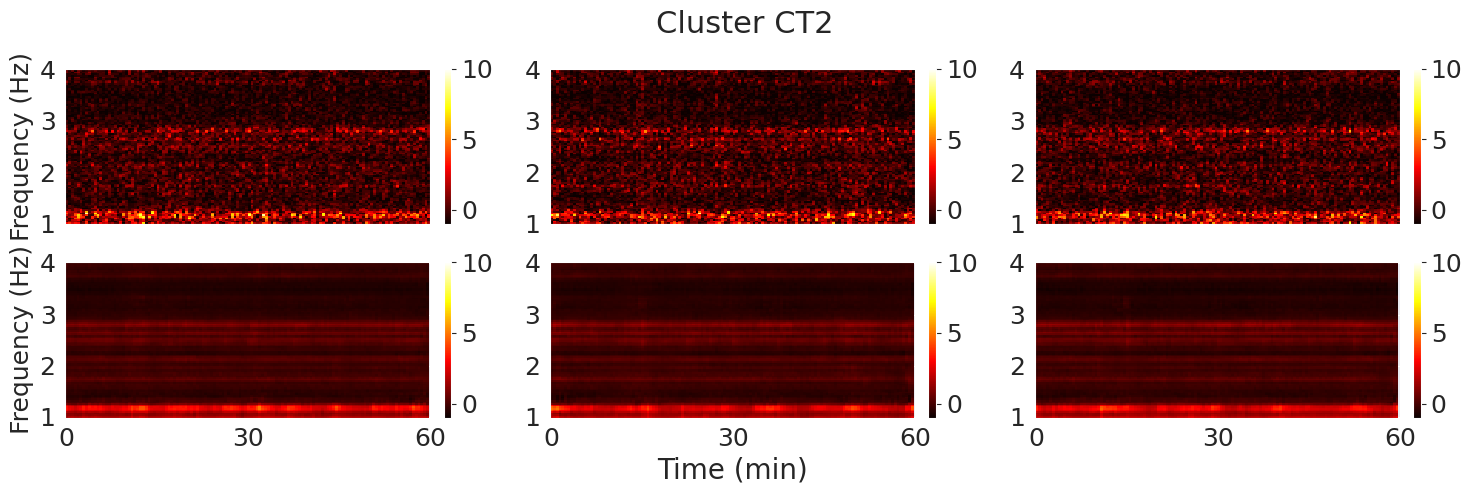

In [29]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec


fig= plt.figure(figsize=(15, 5))
spec = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(data_file[2342,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax1.set(ylabel=None)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax2 = fig.add_subplot(spec[0, 1])

librosa.display.specshow(data_file[2343,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax2.set(ylabel=None)

fig.suptitle ('Cluster CT2', fontsize= 22)

ax3 = fig.add_subplot(spec[0, 2])

librosa.display.specshow(data_file[2344,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax3.set(ylabel=None)

ax4 = fig.add_subplot(spec[1, 0])

librosa.display.specshow(decoded_imgs[2342,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax4.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)
plt.ylabel('Frequency (Hz)', fontsize= 18)

ax5 = fig.add_subplot(spec[1, 1])

librosa.display.specshow(decoded_imgs[2343,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax5.set(ylabel=None)
ax5.set_xlabel("Time (min)", fontsize= 20)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

ax6 = fig.add_subplot(spec[1, 2])

librosa.display.specshow(decoded_imgs[2344,0,:,:], alpha=None, cmap='hot', antialiased=True,y_axis='linear', sr= 8, vmin=-1 , vmax=10)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
freq =[0,1.33, 2.66, 4]
labelsy = [1,2,3, 4]
plt.yticks (freq, labelsy, fontsize= 18)
ax6.set(ylabel=None)
labelsx = [0,30,60]
plt.xticks(np.arange(0,128, 63.999), labelsx, fontsize= 18)

plt.tight_layout()    
plt.savefig ('In&out-CT2.png', dpi=100)
plt.show()